<img src="https://www.davidkiger.com/wp-content/uploads/2016/12/0bd3375.png" alt="Drawing" style="width: 975px;"/>

# Longitudinal MRI Data in Nondemented and Demented Older Adults 

###### This set consists of a longitudinal collection of 150 subjects aged 60 to 96. Each subject was scanned on two or more visits, separated by at least one year for a total of 373 imaging sessions. For each subject, 3 or 4 individual T1-weighted MRI scans obtained in single scan sessions are included. The subjects are all right-handed and include both men and women. 72 of the subjects were characterized as nondemented throughout the study. 64 of the included subjects were characterized as demented at the time of their initial visits and remained so for subsequent scans, including 51 individuals with mild to moderate Alzheimer’s disease. Another 14 subjects were characterized as nondemented at the time of their initial visit and were subsequently characterized as demented at a later visit.

### Libraries, Tools, & Data Used

In [244]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, roc_curve, auc

%matplotlib inline

sns.set()

df = pd.read_csv('mri-and-alzheimers/oasis_longitudinal.csv')


### Data Exploration, Pre-Processing, Cleaning

#### ID : Identification , M/F: Gender , Hand: Dominant Hand , Age: Age in years , Educ: Education Level, SES: Socioeconomic Status, MMSE: Mini Mental State Examination, CDR: Clinical Dementia Rating, eTIV: Estimated Total Intracranial Volume, nWBV: Normalize Whole Brain Volume, ASF: Atlas Scaling Factor, Delay: Delay

In [245]:
df.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


#### df.drop utlized to remove unnecessary columns. i.e 'MRI ID' not a useful feature for the purpose of identifying early onset of Alzheimer's

In [246]:
df = df.reset_index(drop=True) # reset index after filtering first visit data
df['M/F'] = df['M/F'].replace(['F','M'], [0,1]) # M/F column
df['Group'] = df['Group'].replace(['Converted'], ['Demented']) # Target variable
df['Group'] = df['Group'].replace(['Demented', 'Nondemented'], [1,0]) # Target variable
df = df.drop(['MRI ID', 'Visit', 'Hand'], axis=1) # Drop unnecessary columns

#### New Dataframe created minus 'MRI ID', 'Visit', 'Hand'

In [247]:
df.head()

,Subject ID,Group,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,0,0,1,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,0,457,1,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,1,0,1,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,1,560,1,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,1,1895,1,80,12,NaN,22.0,0.5,1698,0.701,1.034


#### Identifying Missing Values 

In [248]:
pd.isnull(df).sum() 

Subject ID     0
Group          0
MR Delay       0
M/F            0
Age            0
EDUC           0
SES           19
MMSE           2
CDR            0
eTIV           0
nWBV           0
ASF            0
dtype: int64

#### Removing Missing Values

In [249]:
df = df.dropna(axis=0, how='any')
pd.isnull(df).sum()

Subject ID    0
Group         0
MR Delay      0
M/F           0
Age           0
EDUC          0
SES           0
MMSE          0
CDR           0
eTIV          0
nWBV          0
ASF           0
dtype: int64

### Data is Now Cleaned, Ready for Analysis, & Determining Relationships

### Examining Relationship Between Gender and Dementia

In [250]:
def bar_chart(feature):
    Demented = df[df['Group']==1][feature].value_counts()
    Nondemented = df[df['Group']==0][feature].value_counts()
    df_bar = pd.DataFrame([Demented,Nondemented])
    df_bar.index = ['Demented','Nondemented']
    df_bar.plot(kind='bar',stacked=True, figsize=(8,5))

#### The graph below indicates that men are more likely to have dementia than woman. 

Text(0.5, 1.0, 'Gender and Demented rate')

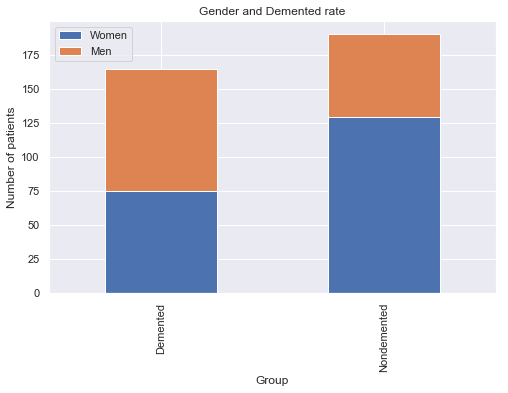

In [251]:
bar_chart('M/F')
plt.xlabel('Group')
plt.ylabel('Number of patients')
plt.legend(labels=['Women', 'Men'])
plt.title('Gender and Demented rate')

### Examining Relationship Between Non-Demented and Demented Groups with Mini Mental State Examination

#### The chart below shows that the Nondemented group had higher MMSE score than the Demented Group

/anaconda3/lib/python3.7/site-packages/matplotlib/legend.py:1270: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  warnings.warn("You have mixed positional and keyword arguments, some "


(15.3, 30.0)

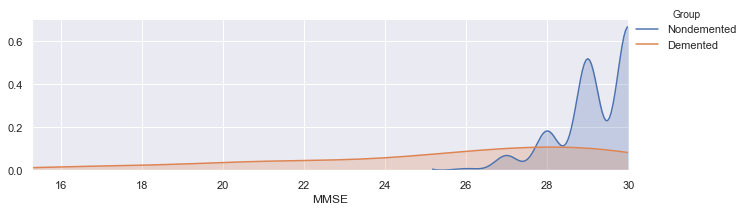

In [252]:
#MMSE : Mini Mental State Examination
# Nondemented = 0, Demented =1
# Nondemented has higher test result ranging from 25 to 30. 
#Min 17 ,MAX 30
facet= sns.FacetGrid(df,hue="Group", aspect=3)
facet.map(sns.kdeplot,'MMSE',shade= True)
facet.set(xlim=(0, df['MMSE'].max()))
facet.add_legend(labels=['Nondemented', 'Demented'])
plt.xlim(15.30)

### Examining Relationships Between Demented & Non-Demented Groups with the Atlas Scaling Factor 

#### Background Info: Atlas Scaling Factor is defined as the volume-scaling factor required to match each individual to the atlas target. Because atlas normalization equates head size, the ASF should be proportional to total intracranial volume(TIV).

#### From the graph below, the Non-Demented Group had higher values of ASF compared to those in the Demented Group.

/anaconda3/lib/python3.7/site-packages/matplotlib/legend.py:1270: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  warnings.warn("You have mixed positional and keyword arguments, some "


(0.5, 2)

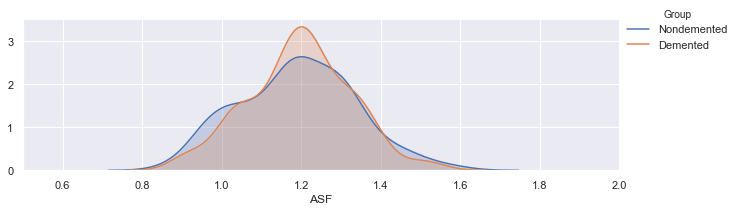

In [253]:
#bar_chart('ASF') = Atlas Scaling Factor
facet= sns.FacetGrid(df,hue="Group", aspect=3)
facet.map(sns.kdeplot,'ASF',shade= True)
facet.set(xlim=(0, df['ASF'].max()))
facet.add_legend(labels=['Nondemented', 'Demented'])
plt.xlim(0.5, 2)

### Examining Relationships Between Demented & Non-Demented Groups with Estimated Total Intracranial Volume 

#### From the graph below, the Non-Demented Group had higher values of eTIV compared to those in the Demented Group. 

/anaconda3/lib/python3.7/site-packages/matplotlib/legend.py:1270: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  warnings.warn("You have mixed positional and keyword arguments, some "


(900, 2100)

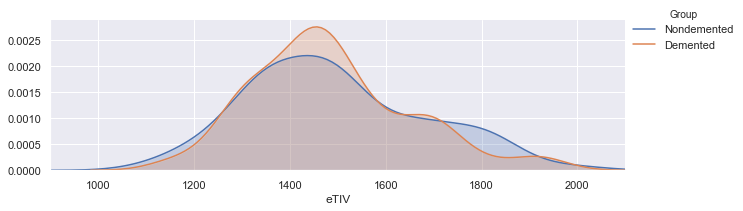

In [254]:
#eTIV = Estimated Total Intracranial Volume
facet= sns.FacetGrid(df,hue="Group", aspect=3)
facet.map(sns.kdeplot,'eTIV',shade= True)
facet.set(xlim=(0, df['eTIV'].max()))
facet.add_legend(labels=['Nondemented', 'Demented'])
plt.xlim(900, 2100)

### Examining Relationships Between Demented & Non-Demented Groups with Normalized Whole Brain Volume

#### The graph below indicates that the Nondemented group has a higher brain volume ratio than the Demented Group. From research this is presumed as Alzheimer's affects the brain by essentially shrinking the volume of the brain. 

/anaconda3/lib/python3.7/site-packages/matplotlib/legend.py:1270: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  warnings.warn("You have mixed positional and keyword arguments, some "


(0.6, 0.9)

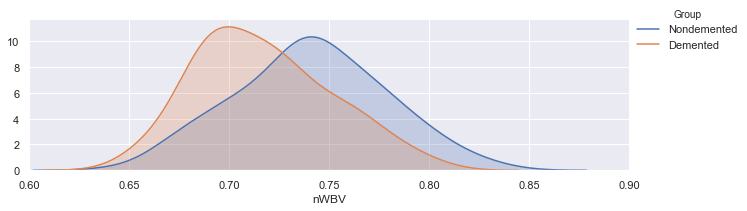

In [255]:
#'nWBV' = Normalized Whole Brain Volume
# Nondemented = 0, Demented =1
facet= sns.FacetGrid(df,hue="Group", aspect=3)
facet.map(sns.kdeplot,'nWBV',shade= True)
facet.set(xlim=(0, df['nWBV'].max()))
facet.add_legend(labels=['Nondemented', 'Demented'])
plt.xlim(0.6,0.9)

### Examining Relationships Between Demented & Non-Demented Groups with Age

#### There is a higher concentration of 70-80 years old in the Demented patient group than those in the nondemented patients. A suggested explanation is that patients who suffered from that kind of disease had lower survival rate so that there are fewer individuals of 90 years old.

/anaconda3/lib/python3.7/site-packages/matplotlib/legend.py:1270: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  warnings.warn("You have mixed positional and keyword arguments, some "


(50, 100)

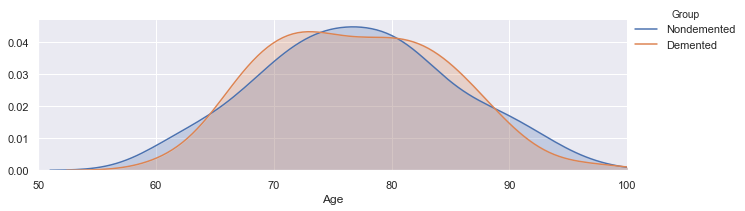

In [256]:
#AGE. Nondemented =0, Demented =0
facet= sns.FacetGrid(df,hue="Group", aspect=3)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, df['Age'].max()))
facet.add_legend(labels=['Nondemented', 'Demented'])
plt.xlim(50,100)

### Inputing Cleaned Dataset, Relevant Features, and Splitting Dataset in Training and Testing Set. 

In [257]:
# Dataset with imputation
Y = df['Group'].values # Target for the model
X = df[['M/F', 'Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF']] # Features we use

# splitting into three sets
X_trainval, X_test, Y_trainval, Y_test = train_test_split(
    X, Y, random_state=0)

# Feature scaling
scaler = MinMaxScaler().fit(X_trainval)
X_trainval_scaled = scaler.transform(X_trainval)
X_test_scaled = scaler.transform(X_test)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [258]:
# Dataset after dropping missing value rows
Y = df['Group'].values # Target for the model
X = df[['M/F', 'Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF']] # Features we use

# splitting into three sets
X_trainval_dna, X_test_dna, Y_trainval_dna, Y_test_dna = train_test_split(
    X, Y, random_state=0)

# Feature scaling
scaler = MinMaxScaler().fit(X_trainval_dna)
X_trainval_scaled_dna = scaler.transform(X_trainval_dna)
X_test_scaled_dna = scaler.transform(X_test_dna)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [259]:
acc = [] #list to store all performance metric 

### Utlizing Random Forest Classifier w/Cross Validation Utlizing Estimated Best Parameters

In [260]:
best_score = 0
kfolds = 5

for M in range(2, 15, 2): # combines M trees
    for d in range(1, 9): # maximum number of features considered at each split
        for m in range(1, 9): # maximum depth of the tree
            # train the model
            # n_jobs(4) is the number of parallel computing
            forestModel = RandomForestClassifier(n_estimators=M, max_features=d, n_jobs=4,
                                          max_depth=m, random_state=0)
        
            # perform cross-validation
            scores = cross_val_score(forestModel, X_trainval_scaled, Y_trainval, cv=kfolds, scoring='accuracy')

            # compute mean cross-validation accuracy
            score = np.mean(scores)

            # if we got a better score, store the score and parameters
            if score > best_score:
                best_score = score
                best_M = M
                best_d = d
                best_m = m

# Rebuild a model on the combined training and validation set        
SelectedRFModel = RandomForestClassifier(n_estimators=M, max_features=d,
                                          max_depth=m, random_state=0).fit(X_trainval_scaled, Y_trainval )

PredictedOutput = SelectedRFModel.predict(X_test_scaled)
test_score = SelectedRFModel.score(X_test_scaled, Y_test)
test_recall = recall_score(Y_test, PredictedOutput, pos_label=1)
fpr, tpr, thresholds = roc_curve(Y_test, PredictedOutput, pos_label=1)
test_auc = auc(fpr, tpr)
print("Best accuracy on validation set is:", best_score)
print("Best parameters of M, d, m are: ", best_M, best_d, best_m)
print("Test accuracy with the best parameters is", test_score)
print("Test recall with the best parameters is:", test_recall)
print("Test AUC with the best parameters is:", test_auc)

m = 'Random Forest'
acc.append([m, test_score, test_recall, test_auc, fpr, tpr, thresholds])

Best accuracy on validation set is: 0.849252808686771
Best parameters of M, d, m are:  14 1 6
Test accuracy with the best parameters is 0.7752808988764045
Test recall with the best parameters is: 0.675
Test AUC with the best parameters is: 0.7660714285714287


In [315]:
print("Feature Importance: ")
names = index=X.columns
feat_importances = (sorted(zip(map(lambda x: round(x,4),SelectedRFModel.feature_importances_),names),reverse=True))
feat_importances

Feature Importance: 


[(0.431, 'MMSE'),
 (0.1384, 'nWBV'),
 (0.1017, 'Age'),
 (0.0969, 'eTIV'),
 (0.0887, 'ASF'),
 (0.0709, 'EDUC'),
 (0.0523, 'SES'),
 (0.0201, 'M/F')]

### Feature Importanct: How Important the Features Are Within the DataSet in Predicting Individuals Being Either Demented or Non-Demented.

Text(0.5, 1.0, 'Feature Importance Within Alzheimers Dataset')

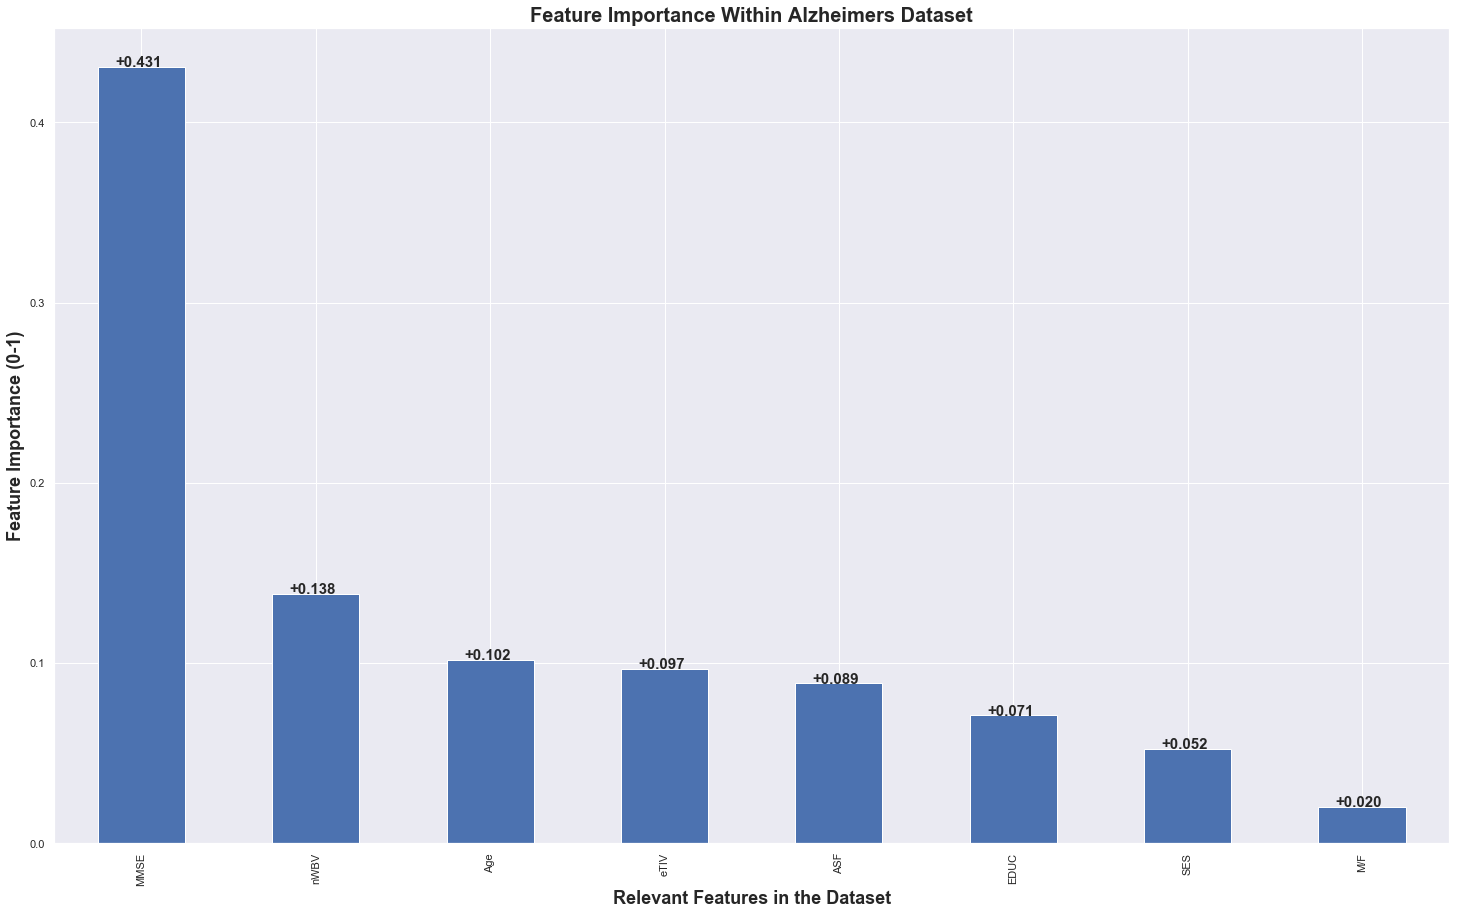

In [316]:
feat_import = pd.Series(SelectedRFModel.feature_importances_, index=X.columns)
plt.figure(figsize=(25,15))
ax4 = feat_import.nlargest(10).plot(kind='bar')
x_offset = -0.15
y_offset = 0.0
for p in ax4.patches:
    b = p.get_bbox()
    val = "{:+.3f}".format(b.y1 + b.y0)        
    ax4.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset),fontsize=15, fontweight='bold')

plt.xlabel('Relevant Features in the Dataset',fontsize=18,fontweight='bold')
plt.ylabel('Feature Importance (0-1)',fontsize=18, fontweight='bold')
plt.title('Feature Importance Within Alzheimers Dataset',fontsize=20, fontweight='bold')

#### Most important feature related to predicting demented vs. nondemented individuals is MMSE(Mini Mental State Examination) followed by a drastic drop off with nWBV(Normalize Whole Brain Volume) and subsequent features within the dataset. 